# Flagging Loans

## Table of Contents

- [Objective](#objective)
- [Setup](#setup)
- [Data Exploration](#data-exploration)
- [Feature Engineering](#feature-engineering)
- [Algorithm Selection](#algorithm-selection)
- [Addressing Class Imbalance](#class-imbalance)
- [Hyperparameter Optimization](#hyperparameter-optimization)

## Objective <a id='objective'></a>

The `test_task.csv` file contains data on repeated loans from existing clients.

This notebook shows the approach and process for building a model to predict the value of the target variable, `bad_flag`. The expected default rate at different approval levels will be demonstrated.

## Setup

In [1]:
# Import libraries
import pandas as pd
import warnings
from seaborn import displot

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

# Visualization for scikit-learn
from yellowbrick.classifier import ClassificationReport

# Hyperparameter optimization
import optuna

In [2]:
# Ignore warning messages
warnings.filterwarnings('ignore')

In [3]:
# Fix random seed for reproducible results
random_seed = 42

## Data Exploration <a id='data-exploration'></a>

In [4]:
# Read data
data = pd.read_csv('data/raw/test_task.csv')

In [5]:
# Shape of data
data.shape

(4157, 22)

In [6]:
# Sample of data
data.sample(n=10, random_state=random_seed)

,loanKey,rep_loan_date,first_loan,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,first_overdue_date,close_loans_cnt,federal_district_nm,TraderKey,...,payment_type_2,payment_type_3,payment_type_4,payment_type_5,past_billings_cnt,score_1,score_2,age,gender,bad_flag
2481,798820,2016-11-07,2015-09-07,NaN,NaN,NaN,NaN,7.0,region_3,6,...,16,0,0,0,14.0,550.235369,NaN,43.0,False,0
308,612648,2016-08-18,2016-02-08,NaN,NaN,NaN,NaN,1.0,region_6,12,...,0,2,0,0,6.0,NaN,576.875277,26.0,False,0
2414,452498,2016-04-20,2016-03-12,NaN,NaN,NaN,NaN,0.0,region_2,12,...,0,2,1,0,1.0,561.999471,NaN,28.0,True,1
2720,580963,2016-07-22,2015-08-14,NaN,NaN,NaN,NaN,1.0,region_6,26,...,5,6,0,0,10.0,590.376406,NaN,30.0,False,0
463,518998,2016-06-01,2015-09-29,NaN,NaN,NaN,NaN,1.0,region_3,6,...,8,0,0,0,8.0,593.493342,NaN,47.0,False,0
1185,295047,2015-12-23,2015-12-22,NaN,NaN,NaN,NaN,NaN,region_2,6,...,0,0,0,0,NaN,NaN,NaN,19.0,False,0
96,247067,2015-11-17,2015-10-15,NaN,NaN,NaN,NaN,0.0,region_3,12,...,0,0,0,0,1.0,601.979112,NaN,27.0,False,1
2031,388069,2016-03-16,2015-10-10,NaN,NaN,NaN,NaN,1.0,region_3,6,...,2,0,0,0,3.0,NaN,NaN,24.0,False,0
1886,736698,2016-10-16,2015-10-16,2.0,1.0,0.0,2015-12-20,2.0,region_6,6,...,5,0,0,0,5.0,NaN,NaN,20.0,False,1
843,628262,2016-08-28,2015-08-08,NaN,NaN,NaN,NaN,1.0,region_3,38,...,3,0,0,0,3.0,634.387608,NaN,46.0,False,0


In [7]:
# Information on DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4157 entries, 0 to 4156
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loanKey              4157 non-null   int64  
 1   rep_loan_date        4157 non-null   object 
 2   first_loan           4157 non-null   object 
 3   dpd_5_cnt            675 non-null    float64
 4   dpd_15_cnt           675 non-null    float64
 5   dpd_30_cnt           675 non-null    float64
 6   first_overdue_date   675 non-null    object 
 7   close_loans_cnt      4142 non-null   float64
 8   federal_district_nm  4146 non-null   object 
 9   TraderKey            4157 non-null   int64  
 10  payment_type_0       4157 non-null   int64  
 11  payment_type_1       4157 non-null   int64  
 12  payment_type_2       4157 non-null   int64  
 13  payment_type_3       4157 non-null   int64  
 14  payment_type_4       4157 non-null   int64  
 15  payment_type_5       4157 non-null   i

In [8]:
# Summary statistics for columns of numerical data types except `loanKey` and target variable `bad_flag`
data.select_dtypes(include='number').drop(columns=['loanKey', 'bad_flag']).describe()

,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,close_loans_cnt,TraderKey,payment_type_0,payment_type_1,payment_type_2,payment_type_3,payment_type_4,payment_type_5,past_billings_cnt,score_1,score_2,age
count,675.000000,675.000000,675.000000,4142.000000,4157.000000,4157.000000,4157.000000,4157.000000,4157.000000,4157.000000,4157.0,3909.000000,3507.000000,239.000000,4157.000000
mean,1.444444,0.733333,0.280000,1.184693,12.338225,0.018523,0.596103,3.755834,0.758239,0.019485,0.0,4.979023,578.911345,552.546610,34.561222
std,0.900599,0.764572,0.502339,1.723715,9.902927,0.330359,2.564887,3.810703,2.212487,0.245960,0.0,3.491556,48.989869,21.492840,10.834143
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,384.220628,485.874267,18.000000
25%,1.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,2.000000,547.429791,535.545724,26.000000
50%,1.000000,1.000000,0.000000,1.000000,6.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.0,4.000000,588.531315,556.757944,32.000000
75%,2.000000,1.000000,1.000000,2.000000,14.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.0,6.000000,612.323090,567.608057,41.000000
max,7.000000,5.000000,3.000000,31.000000,80.000000,15.000000,81.000000,33.000000,35.000000,7.000000,0.0,21.000000,691.528420,603.311653,74.000000


In [9]:
# Summary statistics for categorical columns
data[['federal_district_nm', 'gender']].describe()

,federal_district_nm,gender
count,4146,4157
unique,8,2
top,region_3,False
freq,1595,3570


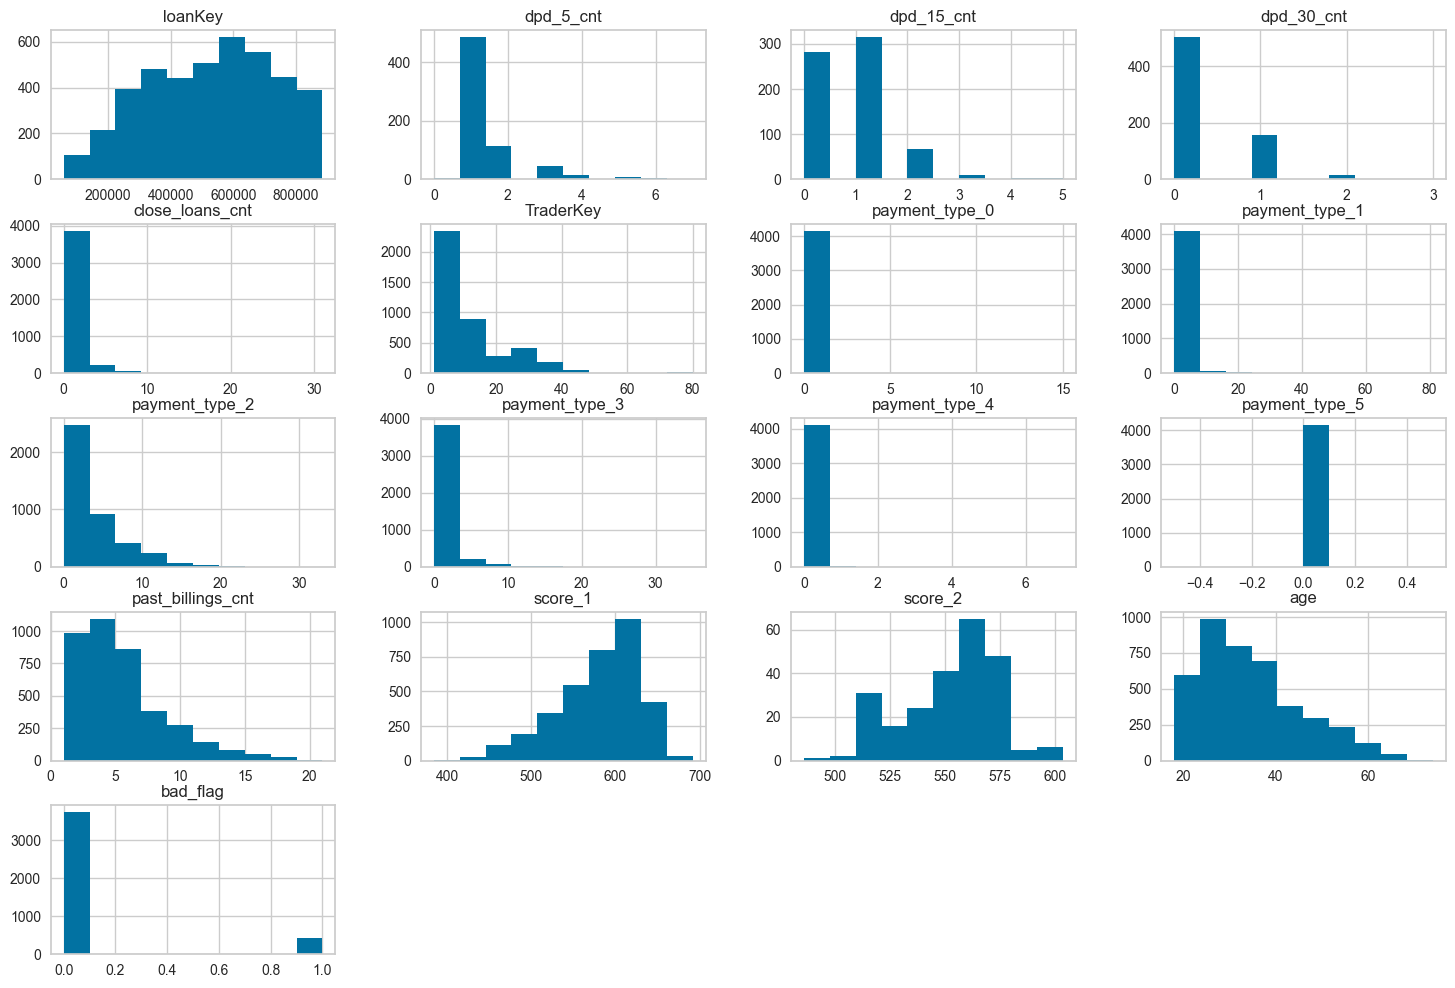

In [10]:
# Plot histograms of data
_ = data.hist(figsize=(18, 12))

In [11]:
# Distribution of target variable
data['bad_flag'].value_counts()

bad_flag
0    3740
1     417
Name: count, dtype: int64

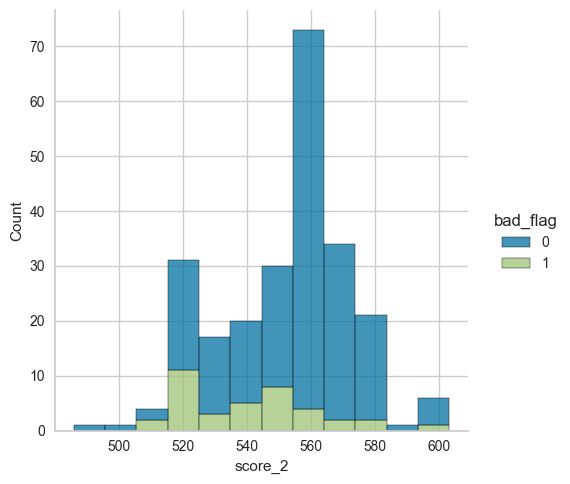

In [12]:
# Plot distribution of `score_2` by `bad_flag`
_ = displot(data=data, x='score_2', hue='bad_flag', multiple='stack')

A distribution plot shows how the positive and negative examples of `bad_flag` are distributed with respect to the selected column.

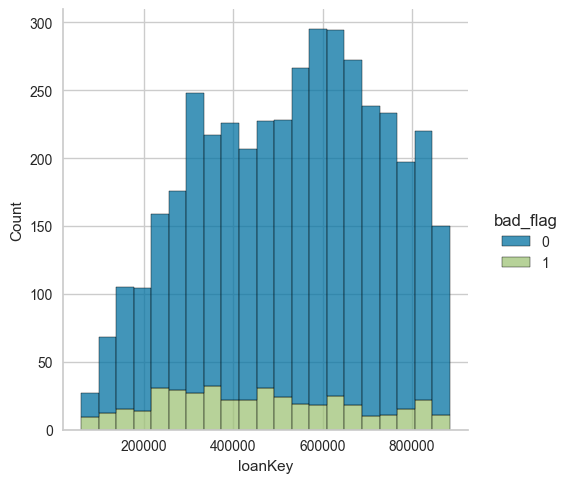

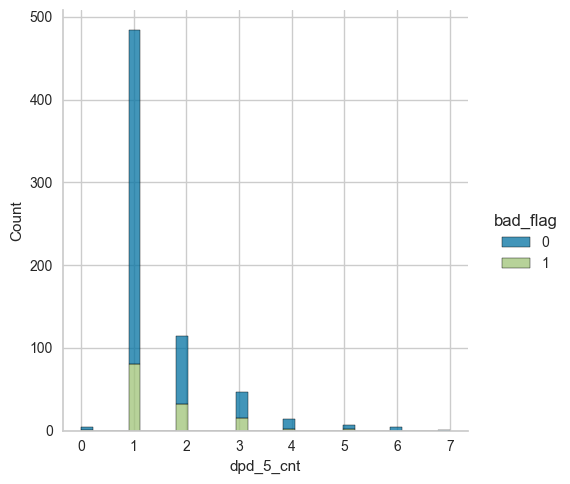

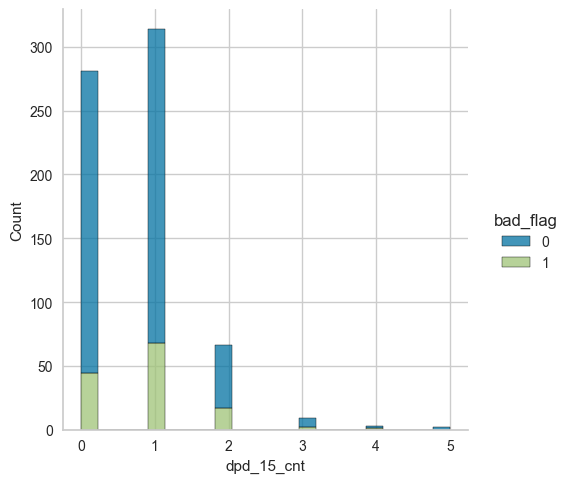

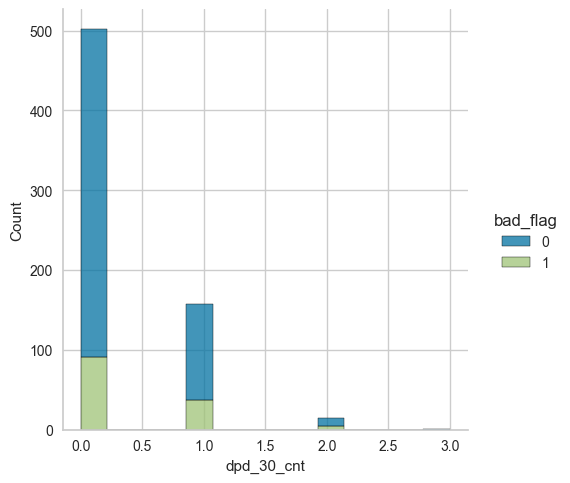

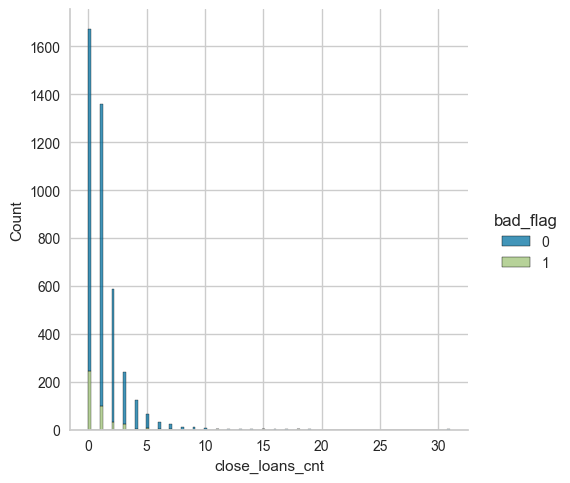

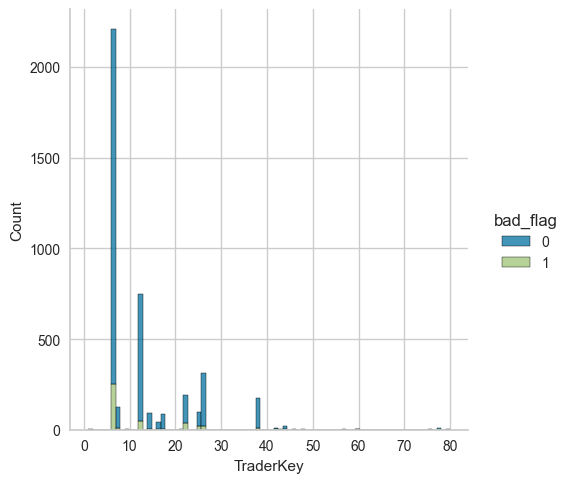

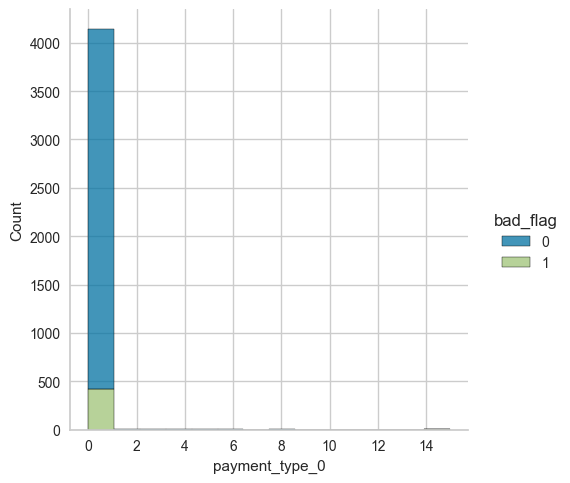

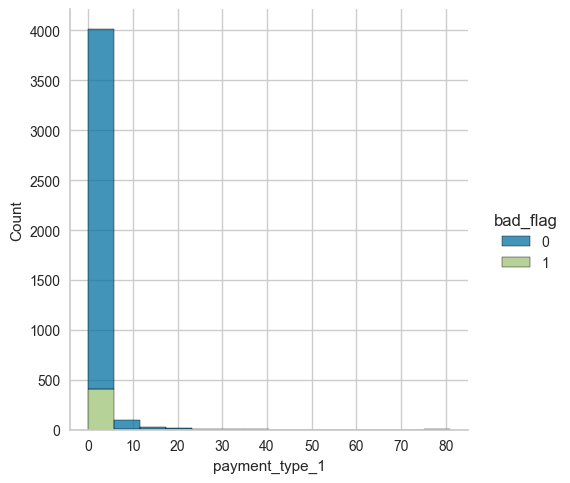

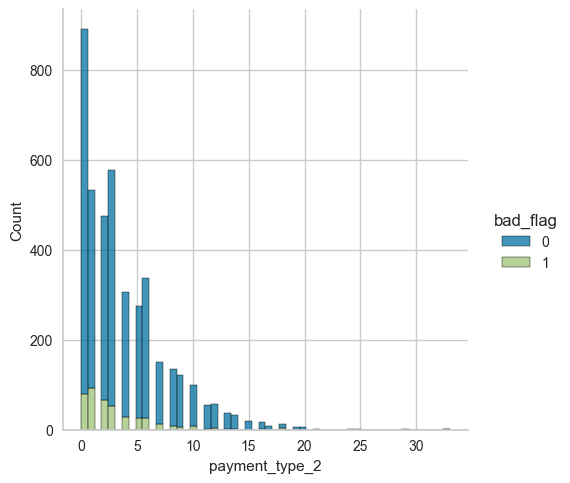

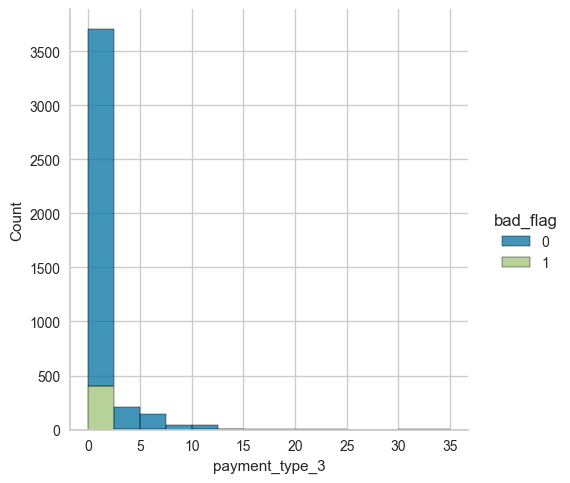

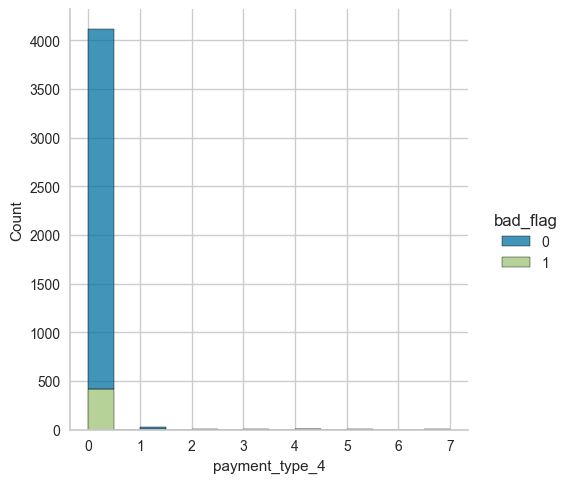

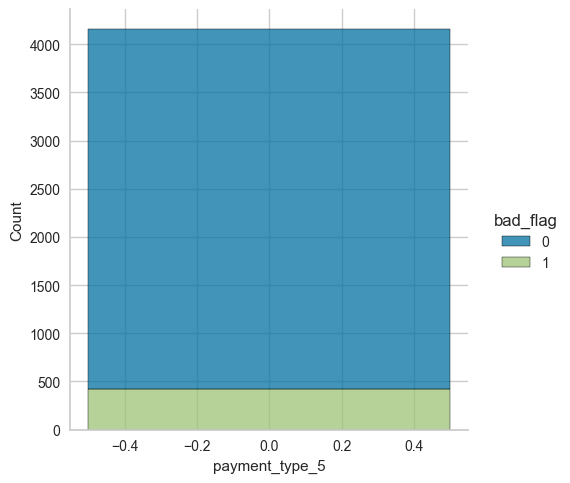

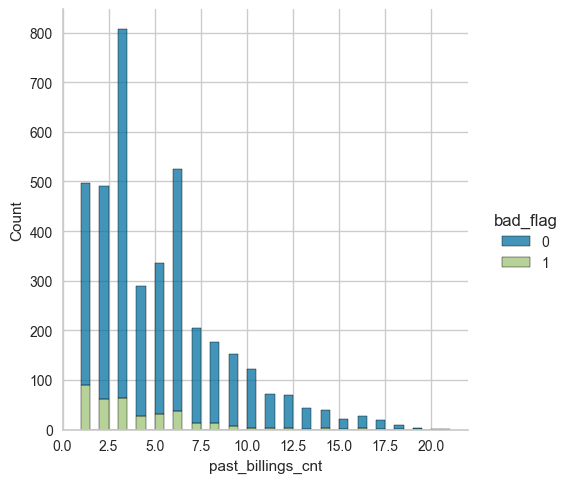

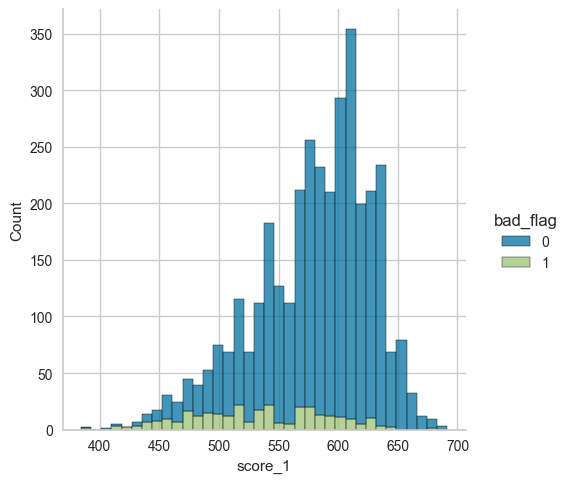

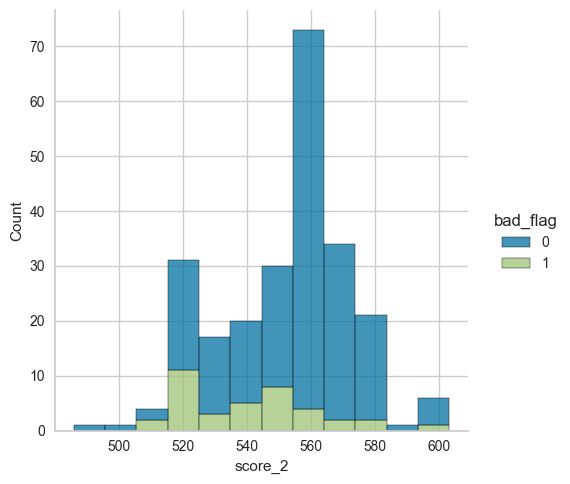

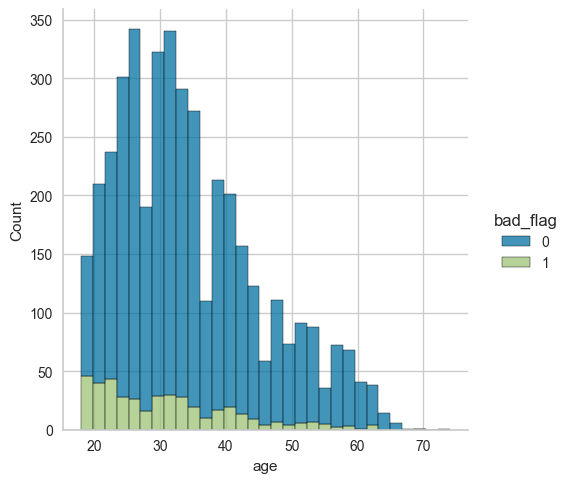

In [13]:
# Plot distribution plots of numerical columns with respect to target variable `bad_flag`
num_columns = data.select_dtypes(include='number').drop(columns='bad_flag').columns

for col in num_columns:
    displot(data=data, x=col, hue='bad_flag', multiple='stack')

## Feature Engineering <a id='feature-engineering'></a>

When processing temporal data with dates, a common feature to calculate is the time difference between events.

In [14]:
# Convert columns to datetime format
data[['rep_loan_date', 'first_loan']] = data[['rep_loan_date', 'first_loan']].apply(pd.to_datetime)

# Calculate time difference in days
data['days_between_rep_and_first_loan'] = (data['rep_loan_date'] - data['first_loan']).dt.days

In [15]:
# Show first 5 rows
data.head()

,loanKey,rep_loan_date,first_loan,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,first_overdue_date,close_loans_cnt,federal_district_nm,TraderKey,...,payment_type_3,payment_type_4,payment_type_5,past_billings_cnt,score_1,score_2,age,gender,bad_flag,days_between_rep_and_first_loan
0,708382,2016-10-06,2015-11-13,NaN,NaN,NaN,NaN,3.0,region_6,6,...,0,0,0,10.0,NaN,NaN,21.0,False,0,328
1,406305,2016-03-26,2015-09-28,1.0,0.0,0.0,2016-01-30,0.0,region_6,6,...,0,0,0,5.0,NaN,NaN,20.0,False,0,180
2,779736,2016-10-30,2015-12-21,NaN,NaN,NaN,NaN,2.0,region_1,6,...,5,0,0,5.0,NaN,NaN,19.0,False,0,314
3,556376,2016-06-29,2015-06-30,NaN,NaN,NaN,NaN,1.0,region_6,14,...,0,0,0,6.0,NaN,NaN,21.0,False,0,365
4,266968,2015-12-01,2015-08-03,NaN,NaN,NaN,NaN,0.0,region_5,22,...,0,0,0,3.0,NaN,NaN,33.0,False,0,120


There are two categorical variables, `gender` and `federal_district_nm`.

The `gender` variable can be used directly with a model because it will be mapped to `True -> 1` and `False -> 0`.

There are 8 unique values for `federal_district_nm` so the pandas' `get_dummies()` method can be used to generate dummy columns.

In [16]:
# Get dummy columns for `federal_district_nm` feature
federal_districts = pd.get_dummies(data['federal_district_nm'], prefix='federal')

In [17]:
# Show first 5 rows
federal_districts.head()

,federal_region_0,federal_region_1,federal_region_2,federal_region_3,federal_region_4,federal_region_5,federal_region_6,federal_region_7
0,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,True,False
2,False,True,False,False,False,False,False,False
3,False,False,False,False,False,False,True,False
4,False,False,False,False,False,True,False,False


In [18]:
# Concatenate data with federal_districts
data = pd.concat(objs=[data, federal_districts], axis=1)

In [19]:
# Fill NaN values with zeroes because most classifiers in this notebook do not accept them
# Zero is a neutral value
data = data.fillna(value=0)

In [20]:
# Sample of data with random seed
data.sample(n=10, random_state=random_seed)

,loanKey,rep_loan_date,first_loan,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,first_overdue_date,close_loans_cnt,federal_district_nm,TraderKey,...,bad_flag,days_between_rep_and_first_loan,federal_region_0,federal_region_1,federal_region_2,federal_region_3,federal_region_4,federal_region_5,federal_region_6,federal_region_7
2481,798820,2016-11-07,2015-09-07,0.0,0.0,0.0,0,7.0,region_3,6,...,0,427,False,False,False,True,False,False,False,False
308,612648,2016-08-18,2016-02-08,0.0,0.0,0.0,0,1.0,region_6,12,...,0,192,False,False,False,False,False,False,True,False
2414,452498,2016-04-20,2016-03-12,0.0,0.0,0.0,0,0.0,region_2,12,...,1,39,False,False,True,False,False,False,False,False
2720,580963,2016-07-22,2015-08-14,0.0,0.0,0.0,0,1.0,region_6,26,...,0,343,False,False,False,False,False,False,True,False
463,518998,2016-06-01,2015-09-29,0.0,0.0,0.0,0,1.0,region_3,6,...,0,246,False,False,False,True,False,False,False,False
1185,295047,2015-12-23,2015-12-22,0.0,0.0,0.0,0,0.0,region_2,6,...,0,1,False,False,True,False,False,False,False,False
96,247067,2015-11-17,2015-10-15,0.0,0.0,0.0,0,0.0,region_3,12,...,1,33,False,False,False,True,False,False,False,False
2031,388069,2016-03-16,2015-10-10,0.0,0.0,0.0,0,1.0,region_3,6,...,0,158,False,False,False,True,False,False,False,False
1886,736698,2016-10-16,2015-10-16,2.0,1.0,0.0,2015-12-20,2.0,region_6,6,...,1,366,False,False,False,False,False,False,True,False
843,628262,2016-08-28,2015-08-08,0.0,0.0,0.0,0,1.0,region_3,38,...,0,386,False,False,False,True,False,False,False,False


## Algorithm Selection <a id='algorithm-selection'></a>

In this case, the problem involves binary classification because the predictions are whether a customer is 'bad'. Different classifiers from the [scikit-learn](https://scikit-learn.org/stable/index.html) library will be used.

Precision, recall, and F1 score are the most common metrics for evaluating classifiers.

Here, classifiers will be built and evaluated first on F1 score, and then on all three metrics.

In [21]:
# Define numerical input columns
X_columns = data.select_dtypes(include='number').drop(columns=['loanKey', 'TraderKey', 'bad_flag']).columns.tolist()
X_columns.append('gender')

# Append categorical columns
X_columns = X_columns + list(federal_districts.columns)

In [22]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data[X_columns], data['bad_flag'], test_size=0.2, stratify=data['bad_flag'], random_state=random_seed)

The hyperparameters for the classifiers are initially set at random. Hyperparameter optimization will be performed in the next section.

In [23]:
# Define classifiers in a list
classifiers = [
    SGDClassifier(max_iter=1000, tol=1e-3, random_state=random_seed),
    KNeighborsClassifier(),
    LogisticRegression(solver='lbfgs', random_state=random_seed),
    LogisticRegressionCV(cv=3, random_state=random_seed),
    BaggingClassifier(random_state=random_seed),
    GaussianNB(),
    RandomForestClassifier(n_estimators=100, random_state=random_seed),
    ExtraTreesClassifier(n_estimators=100, random_state=random_seed)
]

In [24]:
# Iterate over classifiers and print evaluations
for classifier in classifiers:
    # Fit classifier to training data
    classifier.fit(X=X_train, y=y_train)
    
    # Make predictions on test data
    y_pred = classifier.predict(X=X_test)
    
    # Calculate F1 score
    f1 = f1_score(y_true=y_test, y_pred=y_pred)
    
    # Print results
    print(classifier.__class__.__name__, ':', f1)

SGDClassifier : 0.23841059602649006
KNeighborsClassifier : 0.2018348623853211
LogisticRegression : 0.06521739130434782
LogisticRegressionCV : 0.0
BaggingClassifier : 0.1834862385321101
GaussianNB : 0.22459893048128343
RandomForestClassifier : 0.18556701030927836
ExtraTreesClassifier : 0.1782178217821782


The [yellowbrick](https://www.scikit-yb.org/en/latest/) classification report shows a model's performance on different classes.

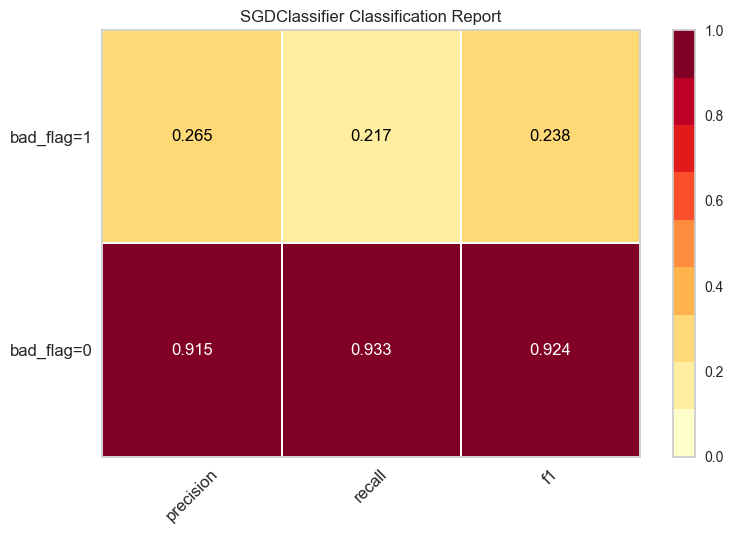

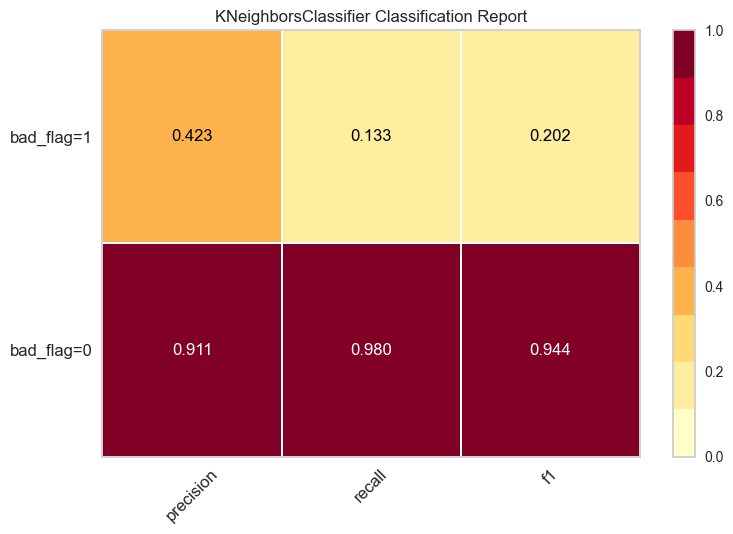

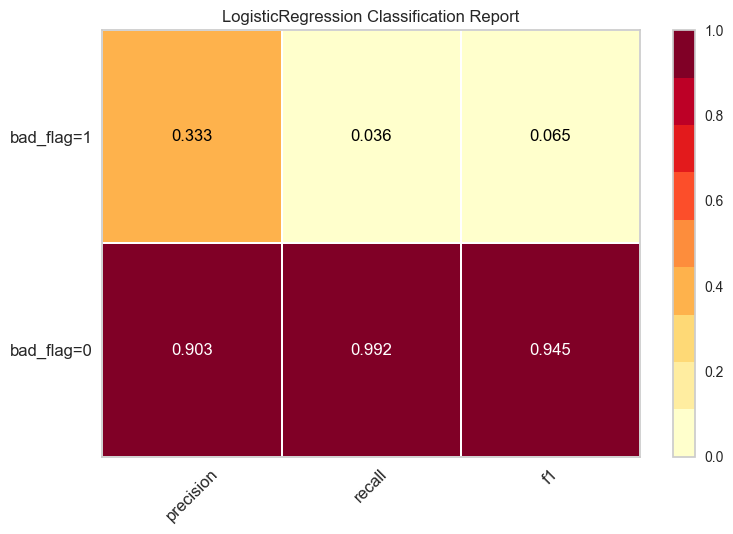

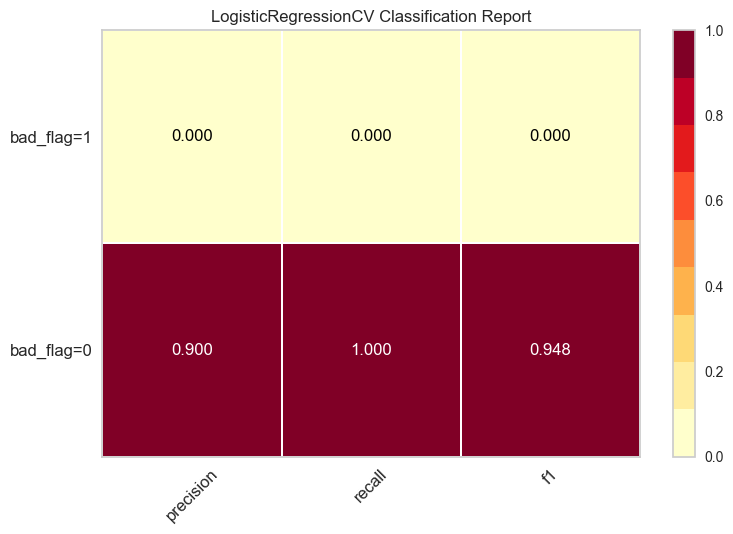

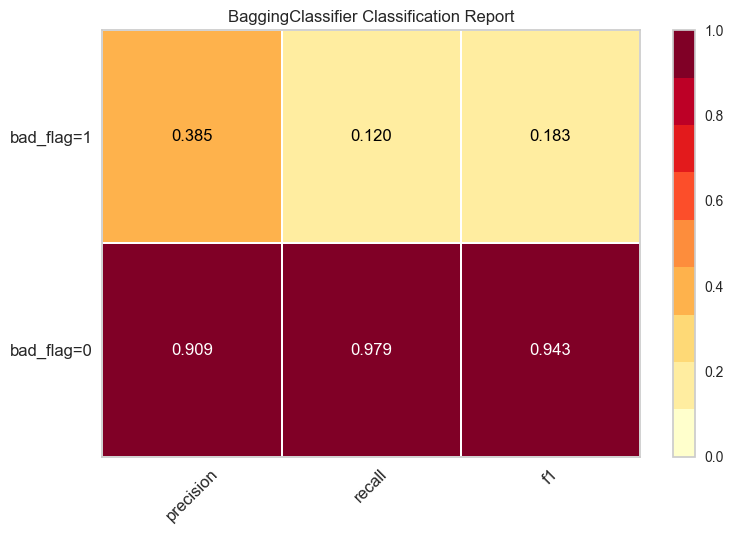

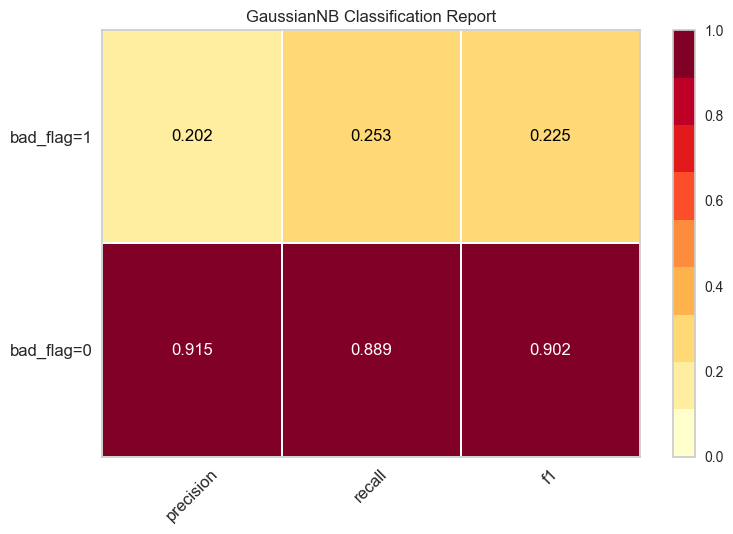

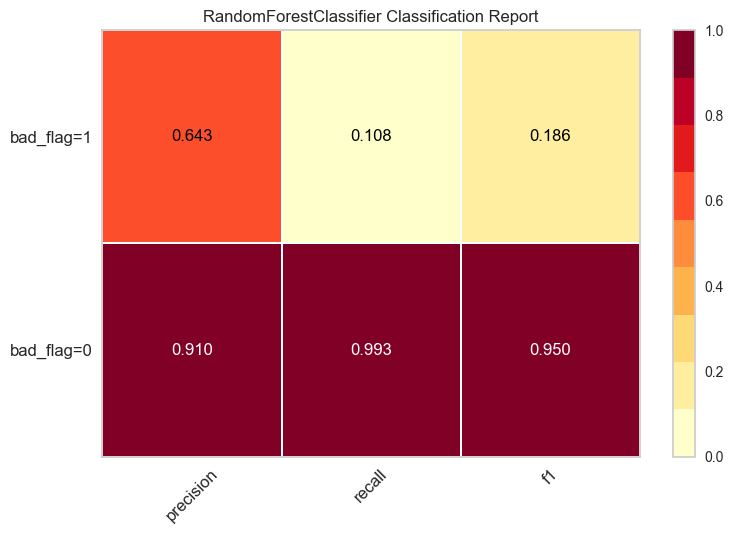

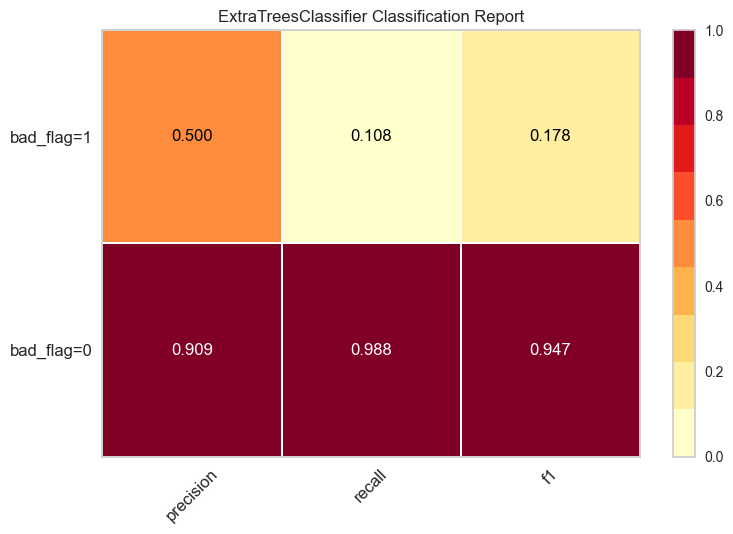

In [25]:
# Iterate over classifiers and visualize classification report
for classifier in classifiers:
    # Create visualizer
    visualizer = ClassificationReport(classifier, classes=['bad_flag=0', 'bad_flag=1'])
    
    # Fit visualizer to training data
    visualizer.fit(X_train, y_train)
    
    # Score visualizer with test data
    visualizer.score(X_test, y_test)
    
    # Display visualization
    visualizer.show()

## Addressing Class Imbalance <a id='class-imbalance'></a>

Class imbalance in datasets should be addressed because many machine learning algorithms ignore or perform poorly on the minority class, which is usually the most important class. 

There are methods to mitigate this issue, including:

- Over-sampling the minority class
- Under-sampling the majority class
- Assigning class weights to data samples
- Synthetically generating new data (e.g. [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html))

These methods aim to bring more balanced class distribution into the data, which may result in building better models due to enhanced performance of machine learning algorithms.

This notebook will show the method of under-sampling the majority class.

In [26]:
# Under-sampling

# Create positive and negative samples
pos_examples = data['bad_flag'].sum()
neg_examples = data.shape[0] - pos_examples

print(f'Positive examples: {pos_examples}\nNegative examples: {neg_examples}')

# Keep all positive examples
pos = data[data['bad_flag'] == 1]

# Use pandas `sample` method to randomly take 20% of negative / majority class
neg = data[data['bad_flag'] == 0].sample(frac=0.2, random_state=random_seed)

print(f'Negative examples after under-sampling: {neg.shape[0]}')

# Concatenate positive and sub-sampled negative samples
data = pd.concat(objs=[pos, neg])

print(f'Final data shape: {data.shape}')

Positive examples: 417
Negative examples: 3740
Negative examples after under-sampling: 748
Final data shape: (1165, 31)


In [27]:
# Split new sampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data[X_columns], data['bad_flag'], test_size=0.2, stratify=data['bad_flag'], random_state=random_seed)

In [28]:
# Iterate new sampled data over classifiers and print evaluations
for classifier in classifiers:
    # Fit classifier to training data
    classifier.fit(X=X_train, y=y_train)
    
    # Make predictions on test data
    y_pred = classifier.predict(X=X_test)
    
    # Calculate F1 score
    f1 = f1_score(y_true=y_test, y_pred=y_pred)
    
    # Print results
    print(classifier.__class__.__name__, ':', f1)

SGDClassifier : 0.5253164556962026
KNeighborsClassifier : 0.6211180124223603
LogisticRegression : 0.4545454545454545
LogisticRegressionCV : 0.4892086330935252
BaggingClassifier : 0.5714285714285715
GaussianNB : 0.42953020134228187
RandomForestClassifier : 0.5974025974025975
ExtraTreesClassifier : 0.5906040268456376


All classifiers appear to show improved performance, with the KNeighbors classifier achieving an F1 score of 0.62.

The confusion matrices will be visualized.

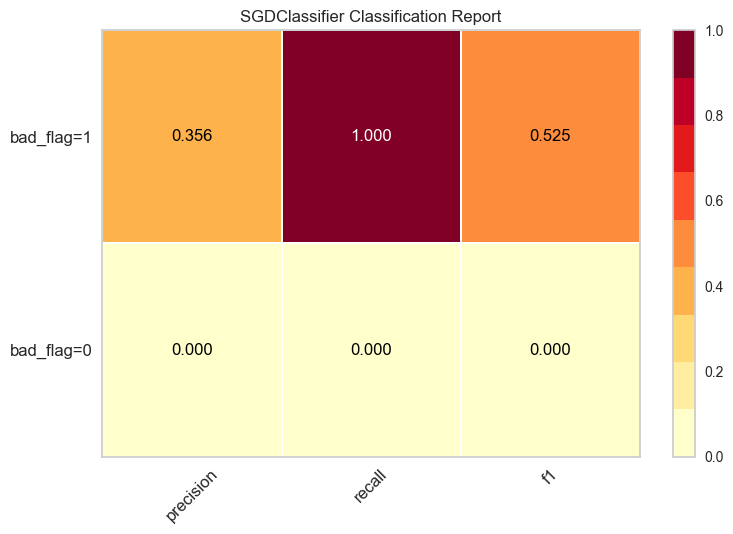

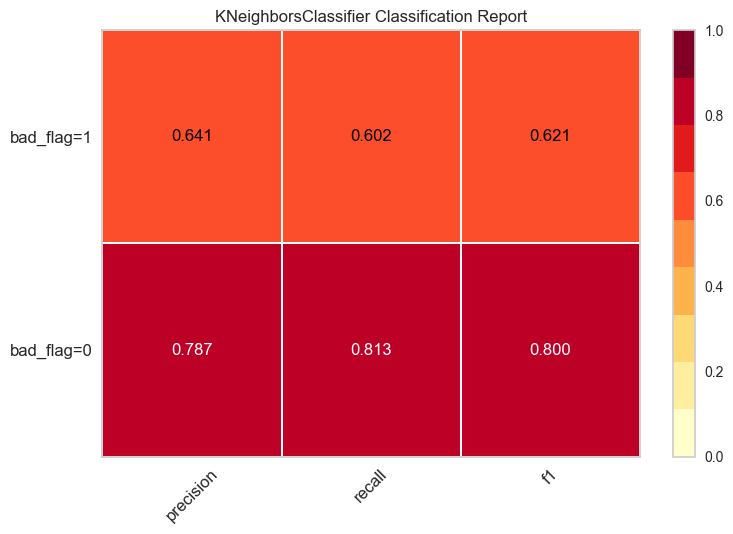

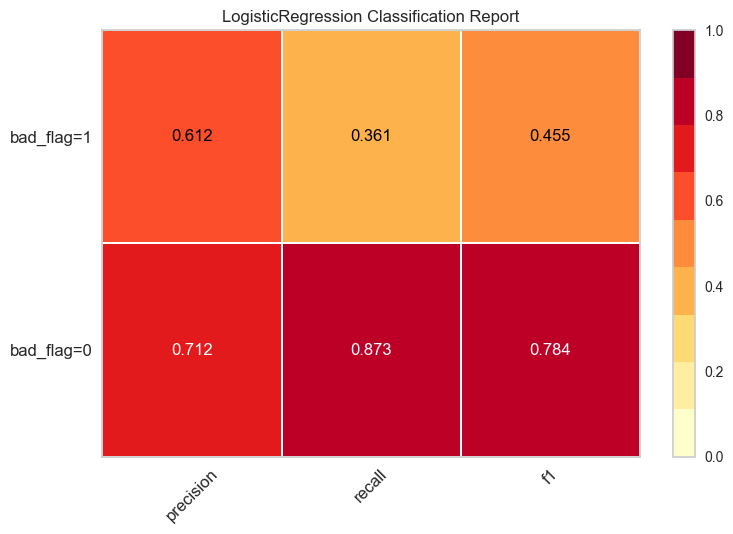

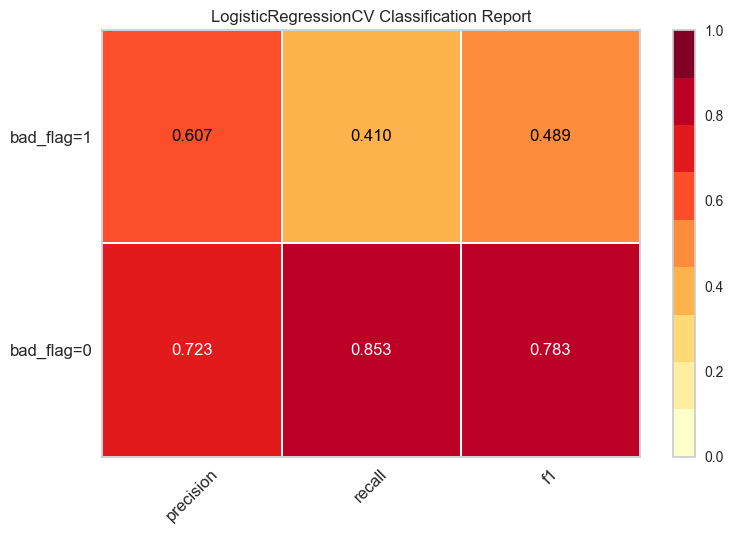

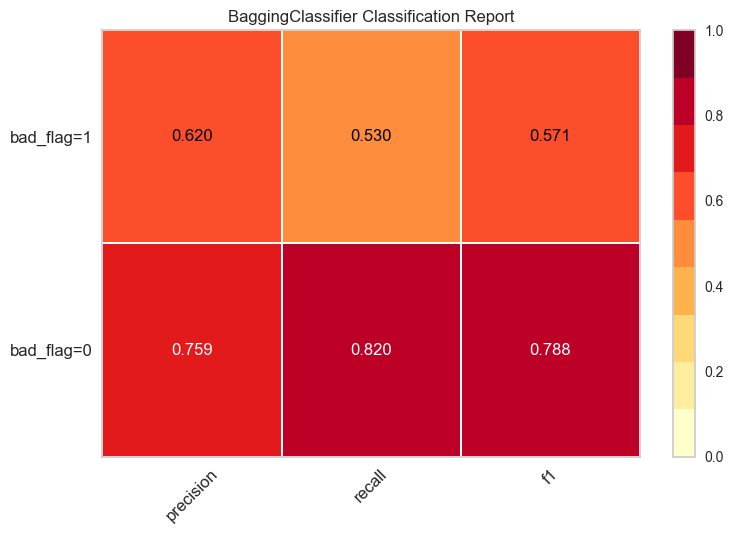

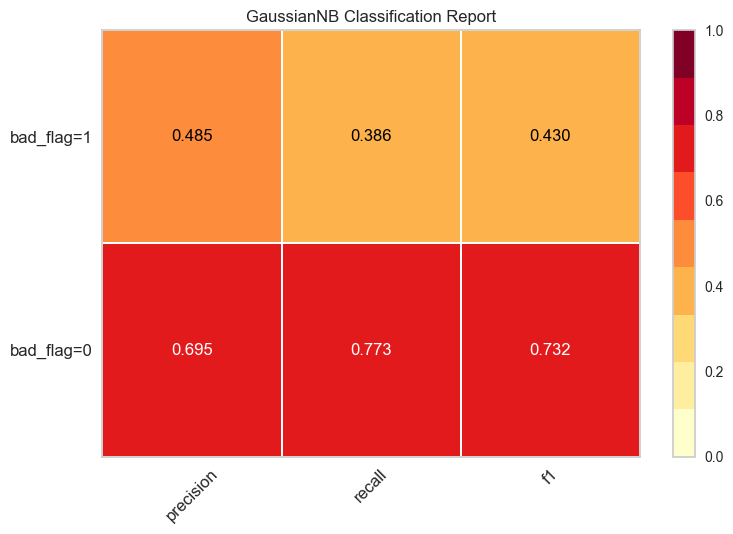

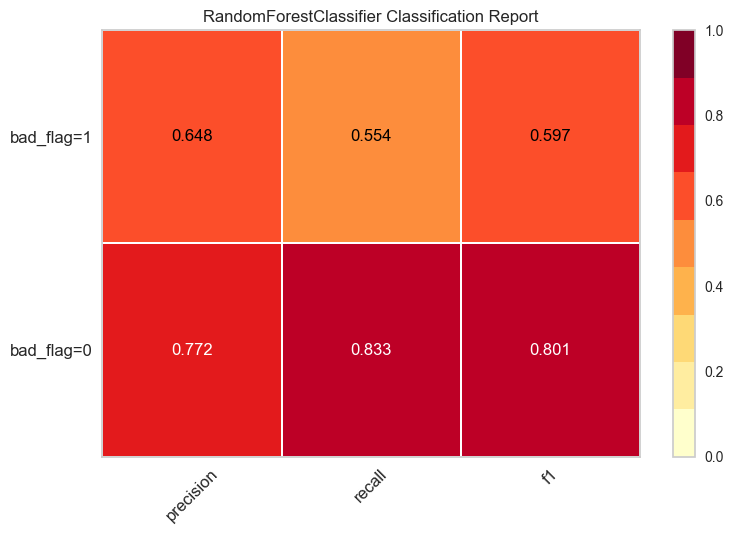

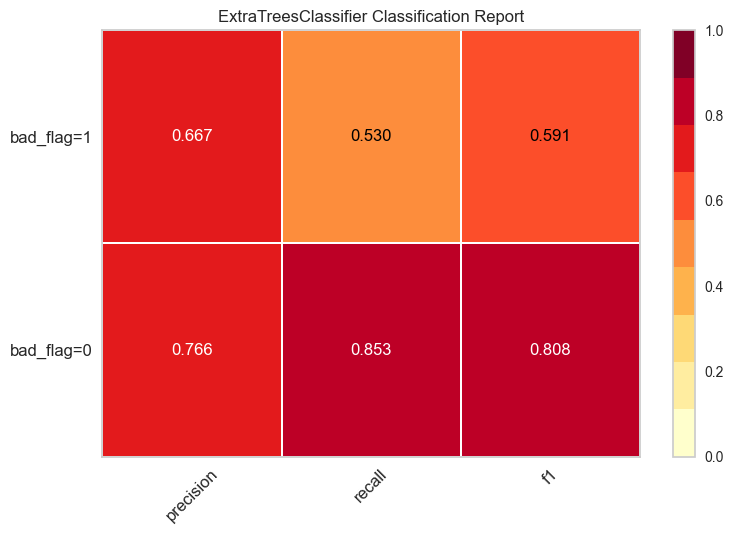

In [29]:
# Iterate over classifiers and visualize classification report
for classifier in classifiers:
    # Create visualizer
    visualizer = ClassificationReport(classifier, classes=['bad_flag=0', 'bad_flag=1'])
    
    # Fit visualizer to training data
    visualizer.fit(X_train, y_train)
    
    # Score visualizer with test data
    visualizer.score(X_test, y_test)
    
    # Display visualization
    visualizer.show()

## Hyperparameter Optimization <a id='hyperparameter-optimization'></a>

The classification reports show that the KNeighbors classifier has the best overall performance.

- All models scored similarly for the negative (majority) class.
- The KNeighbors algorithm has the highest F1 score for the positive (minority) class.

In this section, the algorithm hyperparameters will be modified to improve performance. The [Optuna](https://optuna.org/) framework will be used.

For the KNeighbors classifier, the following hyperparameters will be modified:

- The number of neighbors used during inference
- The weight function used for prediction
- The algorithm used to compute the nearest neighbors

In [30]:
# Define function to optimize hyperparameters of K-Nearest Neighbors classifier with Optuna framework
def objective(trial: optuna.Trial):
    """
    Evaluate a set of hyperparameters for a machine learning model and return a score that Optuna maximizes or minimizes.
    """
    # Suggest minimum and maximum values for parameters to tune
    n_neighbors = trial.suggest_int(name='n_neighbors', low=1, high=10)
    weights = trial.suggest_categorical(name='weights', choices=['uniform', 'distance'])
    algorithm = trial.suggest_categorical(name='algorithm', choices=['ball_tree', 'kd_tree', 'brute'])
    leaf_size = trial.suggest_int(name='leaf_size', low=1, high=40)
    p = trial.suggest_categorical(name='p', choices=[1, 2])
    
    # Create KNeighborsClassifier with suggested hyperparameters
    classifier = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm, leaf_size=leaf_size, p=p)
    
    # Fit classifier on training data
    classifier = classifier.fit(X=X_train, y=y_train)
    
    # Make predictions on test data
    y_pred = classifier.predict(X=X_test)
    
    # Return F1 score as objective to maximize
    return f1_score(y_true=y_test, y_pred=y_pred)

In [31]:
# Create instance of Tree-structured Parzen Estimator (TPE) sampler
# Make sampling process deterministic with `random_seed`
sampler = optuna.samplers.TPESampler(seed=random_seed)

# Create Optuna study
study = optuna.create_study(direction='maximize', study_name='KNeighbors', sampler=sampler)

# Optimize objective function
study.optimize(objective, n_trials=10)

[I 2023-12-06 10:47:46,800] A new study created in memory with name: KNeighbors
[I 2023-12-06 10:47:46,807] Trial 0 finished with value: 0.5594405594405594 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'ball_tree', 'leaf_size': 3, 'p': 1}. Best is trial 0 with value: 0.5594405594405594.
[I 2023-12-06 10:47:46,812] Trial 1 finished with value: 0.5974025974025975 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'ball_tree', 'leaf_size': 8, 'p': 2}. Best is trial 1 with value: 0.5974025974025975.
[I 2023-12-06 10:47:46,818] Trial 2 finished with value: 0.6250000000000001 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 19, 'p': 1}. Best is trial 2 with value: 0.6250000000000001.
[I 2023-12-06 10:47:46,825] Trial 3 finished with value: 0.5594405594405594 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'ball_tree', 'leaf_size': 38, 'p': 1}. Best is trial 2 with value: 0.6250000000

In [32]:
# Get best set of hyperparameters from `study` object as dictionary
study.best_params

{'n_neighbors': 5,
 'weights': 'distance',
 'algorithm': 'brute',
 'leaf_size': 19,
 'p': 1}

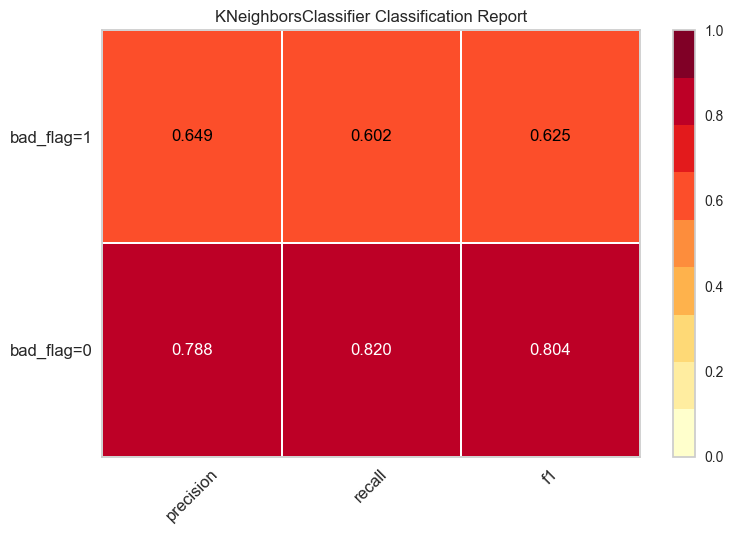

In [33]:
# Classification report

# Create visualizer
visualizer = ClassificationReport(KNeighborsClassifier(**study.best_params), classes=['bad_flag=0', 'bad_flag=1'])
    
# Fit visualizer to training data
visualizer.fit(X_train, y_train)
   
# Score visualizer with test data
visualizer.score(X_test, y_test)
   
# Display visualization
_ = visualizer.show()

The Area Under the Curve (AUC) metric, widely used in classification problems, represents the ratio of false to true positive rates.

A Receiver Operating Characteristic (ROC) curve can be created by sorting data by probability, and plotting false and true positive rates. This visualization can show the model's predictions, the estimation of true and false positive examples, at any given point on the curve.

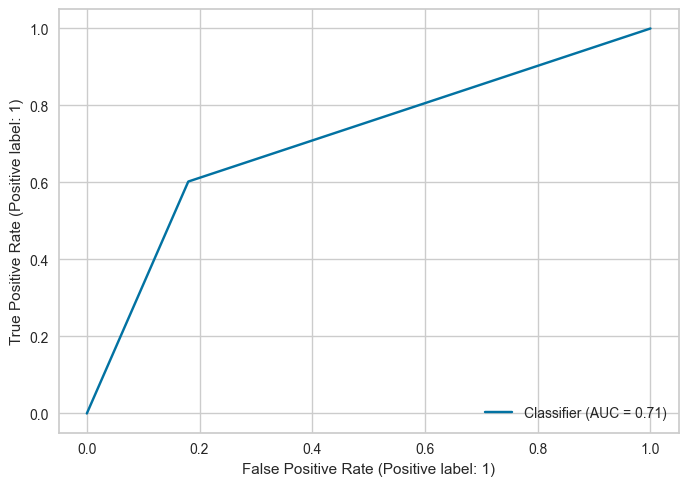

In [34]:
# Plot ROC curve

# Create KNeighborsClassifier with best parameters from study
clf = KNeighborsClassifier(**study.best_params)

# Fit classifier on training data
clf.fit(X=X_train, y=y_train)

# Make predictions on test data
y_pred = clf.predict(X=X_test)

# ROC Curve visualization
_ = RocCurveDisplay.from_predictions(y_test, y_pred)

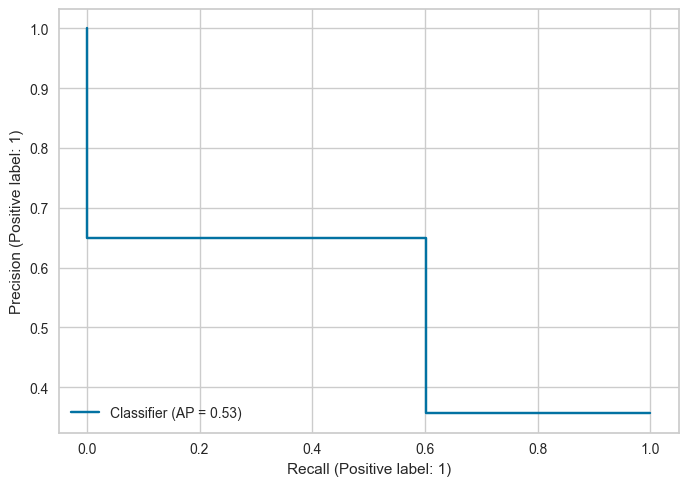

In [35]:
# Plot precision-recall curve
_ = PrecisionRecallDisplay.from_predictions(y_test, y_pred)

This notebook was inspired by the [Flagging Loans](https://platform.stratascratch.com/data-projects/flagging-loans) data project on [StrataScratch](https://www.stratascratch.com/).